In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import fbeta_score
from sklearn.metrics import f1_score
from sklearn.inspection import permutation_importance
from xgboost import XGBClassifier
import xgboost as xgb
from tqdm import tqdm


In [3]:
df = pd.read_csv("./lending_club_2020_train.csv")

df = df.drop(columns=["id",
                      "url",
                      "title",
                      "application_type",
                      "next_pymnt_d",
                      "policy_code",
                      "delinq_amnt",
                      "hardship_flag"])

grade = np.array(df["grade"])
sub_grade = np.array(df["sub_grade"])

encoder = LabelEncoder()
grade_encoded = encoder.fit_transform(grade)
sub_grade_encoded = encoder.fit_transform(sub_grade)

df["grade"] = grade_encoded
df["sub_grade"] = sub_grade_encoded

# 50% 이상 결측치를 가지는 칼럼 drop
df = df.loc[:, (df.isnull().mean() < 0.5) | (df.columns == "loan_status")]
df["int_rate"] = df["int_rate"].str.rstrip("%").astype(float) / 100

# fico_range_low
# data cleansing. add avg fico score column 
insert_loc = df.columns.get_loc('fico_range_low')
df.insert(insert_loc, 'fico_avg', (df['fico_range_low'] + df['fico_range_high']) / 2)

# emp_length
# 2 way of emp_length mapping.
# emp_length이 NaN인 값(무직)을 -1로 매핑, 나머지를 오름차순으로 0~10
# emp_length이 NaN인 값(무직)을 -1로 매핑, 나머지를 오름차순으로 1~11. 무직과 고용상태를 구분하기 위함
label_mapping = {
    '< 1 year': 0,
    '1 year': 1,
    '2 years': 2,
    '3 years': 3,
    '4 years': 4,
    '5 years': 5,
    '6 years': 6,
    '7 years': 7,
    '8 years': 8,
    '9 years': 9,
    '10+ years': 10
}

df['emp_length'] = df['emp_length'].map(label_mapping)
df['emp_length'] = df['emp_length'].fillna(-1)

# term
# categorical variable Labeling
label_mapping = {
    ' 36 months': 36,
    ' 60 months': 60
}

df['term'] = df['term'].map(label_mapping)

# mths_since_last_record
# 마지막 파산 기록 이후 경과된 개월 수
# 이거 유용한 정보인거 같긴 한데, 한국어 번역에 문제가 있는 것같다. 영어 원문에 public record라고 써있는데, public record는 파산을 포함한 공적 기록을 의미한다. 따라서 꼭 파산이 아닐 수도 있음.
# https://credit.org/blogs/blog-posts/understanding-your-public-record-information 해당 링크에 따르면, 판결 등의 정보도 public record에 포함된다.
# 일단 drop

# revol_util
# follow paper (Machine learning and artificial neural networks to construct P2P lending credit-scoring model: A case using Lending Club data), form change percentage form to decimal form
# 결측치는 평균값으로 채워넣는다
df["revol_util"] = df["revol_util"].str.rstrip("%").astype(float) / 100
df['revol_util'] = df['revol_util'].fillna(df['revol_util'].mean())

# tot_coll_amt
# 총 채권 추심 금액
# 결측값만 처리
df["tot_coll_amt"] = df["tot_coll_amt"].fillna(0)

# tot_cur_bal
# 모든 계좌 현재 잔액 합계
# 결측값은 중앙값으로
df["tot_cur_bal"] = df["tot_cur_bal"].fillna(df["tot_cur_bal"].median())

# total_rev_hi_lim
# 리볼빙 총 한도
# 결측값은 중앙값으로
df["total_rev_hi_lim"] = df["total_rev_hi_lim"].fillna(df["total_rev_hi_lim"].median())

# acc_open_past_24mths
# 최근 24개월 동안 개설된 신용거래 건수
# 결측값은 중앙값으로
df["acc_open_past_24mths"] = df["acc_open_past_24mths"].fillna(df["acc_open_past_24mths"].median())

# avg_cur_bal
# 모든 계좌의 평균 현재 잔액
# 결측값은 중앙값으로
df["avg_cur_bal"] = df["avg_cur_bal"].fillna(df["avg_cur_bal"].median())

# bc_open_to_buy
# 리볼빙 은행카드 사용 가능 한도
# 결측값은 중앙값으로
df["bc_open_to_buy"] = df["bc_open_to_buy"].fillna(df["bc_open_to_buy"].median())

# bc_util
# 은행카드 한도 대비 잔액 비율
# 결측값은 평균값으로
df['bc_util'] = df['bc_util'] / 100.0
df['bc_util'] = df['bc_util'].fillna(df['bc_util'].mean())

# dti
# 백분율 정규화
df['dti'] = df['dti'] / 100.0

# mort_acc
# 주택담보대출 계좌 수
# 결측값은 중앙값으로
df["mort_acc"] = df["mort_acc"].fillna(df["mort_acc"].median())

# num_accts_ever_120_pd
# 120일 이상 연체 경험 계좌 수
# 결측값은 중앙값으로
df["num_accts_ever_120_pd"] = df["num_accts_ever_120_pd"].fillna(df["num_accts_ever_120_pd"].median())

# num_actv_bc_tl
# num_actv_rev_tl
# num_bc_sats
# num_bc_tl
# num_il_tl
# num_op_rev_tl
# num_rev_accts
# num_rev_tl_bal_gt_0
# num_sats
# 다 현재 계좌 수에 관련된 칼럼. 나중에 보고 좀 합쳐야할듯
# 결측값은 중앙값으로
cols = [
    'num_actv_bc_tl',
    'num_actv_rev_tl',
    'num_bc_sats',
    'num_bc_tl',
    'num_il_tl',
    'num_op_rev_tl',
    'num_rev_accts',
    'num_rev_tl_bal_gt_0',
    'num_sats'
]

df[cols] = df[cols].fillna(df[cols].median())

# num_tl_90g_dpd_24m : 최근 24개월 90일 이상 연체 계좌 수
# num_tl_op_past_12m : 최근 12개월 개설 계좌 수
# tot_hi_cred_lim : 총 최고 신용 한도
# total_bal_ex_mort : 주택담보 제외 총 잔액
# total_bc_limit : 은행카드 총 한도
# total_il_high_credit_limit : 할부 계좌 총 한도
# 결측값은 중앙값으로
cols = [
    'num_tl_90g_dpd_24m',
    'num_tl_op_past_12m',
    'tot_hi_cred_lim',
    'total_bal_ex_mort',
    'total_bc_limit',
    'total_il_high_credit_limit'
]

df[cols] = df[cols].fillna(df[cols].median())

# pct_tl_nvr_dlq : 연체 경험 없는 계좌 비율
# percent_bc_gt_75 : 한도 75% 초과 은행카드 계좌 비율
# 결측값은 평균으로
cols = ['pct_tl_nvr_dlq', 'percent_bc_gt_75']

df[cols] = df[cols].fillna(df[cols].mean())

# loan_status : 부도 여부, 타겟 변수
# 칼럼 값이 "Fully Paid"가 아닌 값들은 다 default로 판별
# non-default = 0, default = 1
# 'Fully Paid'와 'Charged Off'가 아닌 행 제거
df = df[df['loan_status'].isin(['Fully Paid', 'Charged Off'])]
df['loan_status'] = np.where(df['loan_status'] == 'Fully Paid', 0, 1)

# drop columns
'''
모델링을 위해 필요없어보이는 칼럼을 삭제. 추후에 재검토를 통해 살려서 다시 쓸 수도 있음
zip_code : 알아보니 zip_code 앞 3자리로는 state + city까지 알 수 있던데, 일단 addr_state에서 state는 알 수 있으니 탈락
fico_range_low : fico_range_high와 평균내어 fico_avg라는 파생변수로 만듬
emp_title : 직업이 labeling하기 힘들 정도로 다양하기도 하고 근속 연수와 소득이 더 직관적인 데이터라고 생각해서 탈락
mo_sin_old_il_acct : 가장 오래된 계좌 개설 후 지난 시간. 일단 지우고 도메인팀 협의
mo_sin_old_rev_tl_op : 
mths_since_recent_bc : 최근 계좌 개설 후 지난 시간. 일단 지우고 도메인팀 협의 
mths_since_recent_bc_dlq : 
mths_since_recent_inq : 
mths_since_recent_revol_delinq : 
issue_d : 대출 실행 날짜. 시계열 데이터로 쓸 수 있겠으나 일단 드랍
purpose : 대출 실행 목적. NLP로 처리해야할듯. 일단 드랍
addr_state : 대출 실행시 거주 state
earliest_cr_line : 최초 신용계좌 계설일. 일단 드랍
initial_list_status : 최초 상장 날짜. 일단 드랍
last_credit_pull_d : LC가 최종적으로 신용 조회를 한 날짜. 일단 드랍
debt_settlement_flag : 채무 조정 프로그램에 참여한 상태인가 여부. debt_settlement_flag_date 와 연계해서 쓰면, 대출 실행 이전 시점 데이터를 추릴 수 있겠으나, debt_settlement_flag_date 칼럼이 데이터가 너무 적어서 같이 드랍해야될듯.
mo_sin_rcnt_rev_tl_op : 최근 리볼빙 계좌 계설 경과일
mo_sin_rcnt_tl : 
last_pymnt_d : 시계열 데이터 자르는데 쓸 수 있을거같은데 일단 드랍.
last_pymnt_amnt : 이게 결국 현시점의 총 상환한 금액을 의미하므로 loan_status와 똑같은 값을 의미하게 됌. 
pymnt_plan : 다 n임
total_rec_prncp : 현재까지 수령 원금 last_pymnt_amnt랑 비슷한 논리로 loan_status와 같은 값을 의미하게 될 가능성이 큼
total_rec_int : 현재까지 수령 이자. 마찬가지
'''
df = df.drop(columns=["zip_code",
                      "fico_range_low",
                      "fico_range_high",
                      "emp_title",
                      "mo_sin_old_il_acct",
                      "mo_sin_old_rev_tl_op",
                      "mths_since_recent_bc",
                      "mths_since_recent_inq",
                      "issue_d",
                      "purpose",
                      "addr_state",
                      "earliest_cr_line",
                      "initial_list_status",
                      "last_credit_pull_d",
                      "debt_settlement_flag",
                      "mo_sin_rcnt_rev_tl_op",
                      "mo_sin_rcnt_tl",
                      "last_pymnt_d",
                      "last_pymnt_amnt",
                      "pymnt_plan",
                      "total_rec_prncp",
                      "total_rec_int",
                      "total_pymnt",
                      "total_pymnt_inv"
                      ])



# Qualitative var labeling(nominal var. without ordinal var)

df = pd.get_dummies(df, columns=["home_ownership", "verification_status"], drop_first=True)

# Data cleansing v5
# 채무불이행 이후에 발생하는 데이터를 가진 칼럼 삭제
df = df.drop(columns=["recoveries", "collection_recovery_fee", "collections_12_mths_ex_med", "tot_coll_amt", ])
df = df.dropna(subset=["loan_status"])

df.head()

C:\Users\user\AppData\Local\Temp\ipykernel_88144\2704007742.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./lending_club_2020_train.csv")


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,annual_inc,...,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified
0,6000.0,6000.0,6000.0,36.0,0.0797,187.94,0,4,2.0,45000.0,...,50054.0,15000.0,56511.0,True,False,False,False,False,False,True
2,23200.0,23200.0,23200.0,60.0,0.2499,680.82,4,23,10.0,110000.0,...,294461.0,20300.0,291465.0,True,False,False,False,False,False,True
5,16000.0,16000.0,16000.0,36.0,0.0707,494.55,0,1,-1.0,65000.0,...,32551.0,59100.0,49339.0,True,False,False,False,False,False,False
6,4500.0,4500.0,4500.0,36.0,0.1042,146.10,1,7,5.0,50000.0,...,9573.0,9300.0,11970.0,True,False,False,False,False,False,False
7,20000.0,20000.0,20000.0,36.0,0.0999,645.25,1,7,10.0,60000.0,...,66283.0,11000.0,73090.0,True,False,False,False,False,True,False


In [5]:
df["loan_status"].value_counts()

loan_status
0    898522
1    217366
Name: count, dtype: int64

In [6]:
# 데이터 준비
X = df.drop('loan_status', axis=1)
y = df['loan_status']

# bool타입 정수형으로
# XGBoost가 bool type를 처리할 때 문제를 발생시키는 경우가 있음
bool_columns = X.select_dtypes(include=['bool']).columns.tolist()
X[bool_columns] = X[bool_columns].astype(int)

# 1️⃣ 먼저 Train(80%) / Test(20%) 로 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 2️⃣ Train 데이터에서 Validation(20%) 분리 (즉, Train 80% → Train 75%, Valid 25%)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2/0.8, random_state=42, stratify=y_train)

# 출력해서 확인
print(f"Train set size: {X_train.shape[0]} rows")
print(f"Validation set size: {X_valid.shape[0]} rows")
print(f"Test set size: {X_test.shape[0]} rows")


Train set size: 669532 rows
Validation set size: 223178 rows
Test set size: 223178 rows


최종 선택된 Top 20 Features: ['emp_length', 'dti', 'revol_util', 'fico_avg', 'last_fico_range_high', 'term', 'open_il_24m', 'total_rec_late_fee', 'funded_amnt', 'open_act_il', 'funded_amnt_inv', 'loan_amnt', 'num_tl_30dpd', 'grade', 'installment', 'all_util', 'pub_rec_bankruptcies', 'total_cu_tl', 'open_il_12m', 'int_rate']


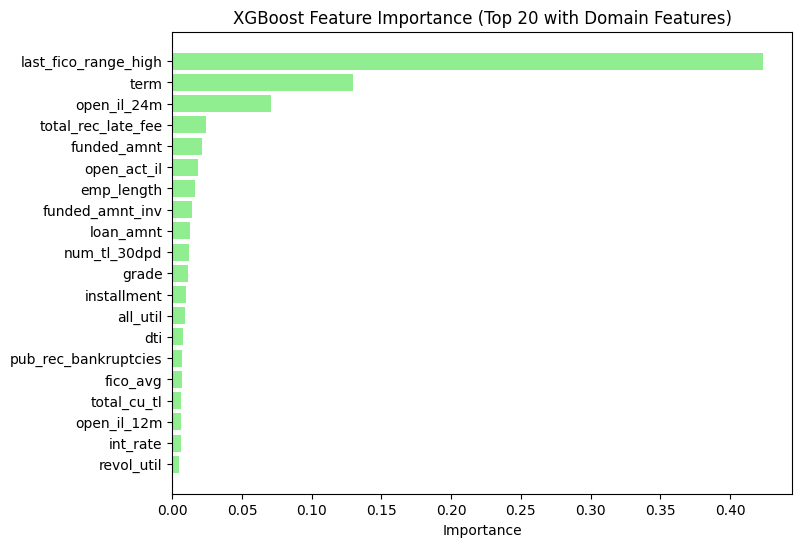

In [7]:
# --- Feature Importance 분석 ---
# 5. XGBoost Classifier
xgb = XGBClassifier(random_state=42, eval_metric='mlogloss')
xgb.fit(X_train, y_train)
xgb_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb.feature_importances_
}).sort_values(by='Importance', ascending=False)

# 반드시 포함해야 하는 도메인 feature
domain_features = ['emp_length', 'dti', 'revol_util', 'fico_avg']

# 이미 xgb_importance_df는 중요도 내림차순 정렬되어 있다고 가정
# 우선 도메인 feature 중, 데이터에 존재하는 것들을 selected에 추가
selected_features = [feat for feat in domain_features if feat in xgb_importance_df['Feature'].values]

# 전체 중요도 순으로 반복하면서, 아직 선택되지 않은 feature들을 채워나감
for feat in xgb_importance_df['Feature']:
    if feat not in selected_features:
        selected_features.append(feat)
    if len(selected_features) >= 20:
        break

# 만약 도메인 feature 때문에 20개보다 많아진 경우, 강제로 20개만 선택하는데,
# 반드시 도메인 feature가 포함되도록 순서를 조정합니다.
# 먼저, 도메인 feature들을 유지하고, 나머지는 importance 순으로 선택합니다.
if len(selected_features) > 20:
    # 도메인 feature들은 유지하고, 나머지 후보 feature들을 importance 순으로 선택
    non_domain = [feat for feat in selected_features if feat not in domain_features]
    # 전체 중요도 데이터프레임에서 도메인 feature와 non_domain feature들의 importance를 가져와서 다시 정렬
    df_selected = xgb_importance_df[xgb_importance_df['Feature'].isin(domain_features + non_domain)]
    # 우선 도메인 feature는 유지하고, 나머지에서 중요도 순으로 채워 20개로 만듦
    final_features = list(domain_features)
    for feat in df_selected['Feature']:
        if feat not in final_features:
            final_features.append(feat)
        if len(final_features) >= 20:
            break
    selected_features = final_features

print("최종 선택된 Top 20 Features:", selected_features)

# 선택된 feature에 해당하는 데이터프레임 생성 (xgb_importance_df에서 해당 행만 필터링)
df_top20 = xgb_importance_df[xgb_importance_df['Feature'].isin(selected_features)]
# 중요도 순으로 다시 정렬 (내림차순)
df_top20 = df_top20.sort_values(by='Importance', ascending=False)

# --- Feature Importance 시각화 ---
def plot_feature_importance(df, title, color='skyblue'):
    plt.figure(figsize=(8, 6))
    plt.barh(df['Feature'], df['Importance'], color=color)
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.xlabel("Importance")
    plt.show()

plot_feature_importance(df_top20, "XGBoost Feature Importance (Top 20 with Domain Features)", 'lightgreen')


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)
Top 20 Features used for XGBoost training: ['last_fico_range_high', 'term', 'open_il_24m', 'total_rec_late_fee', 'funded_amnt', 'open_act_il', 'emp_length', 'funded_amnt_inv', 'loan_amnt', 'num_tl_30dpd', 'grade', 'installment', 'all_util

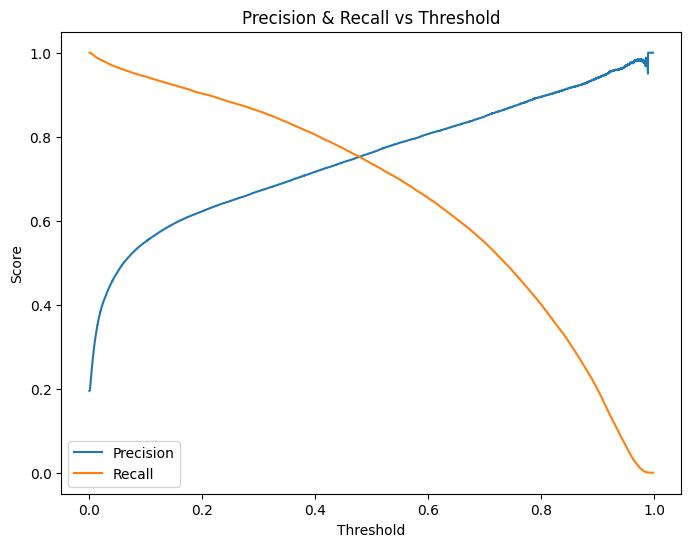

Total thresholds: 221667
Best threshold based on F2 Score: 0.3050
Test Accuracy (adjusted threshold): 0.8912
Test Classification Report (adjusted threshold):
              precision    recall  f1-score   support

           0       0.96      0.90      0.93    179705
           1       0.67      0.86      0.75     43473

    accuracy                           0.89    223178
   macro avg       0.82      0.88      0.84    223178
weighted avg       0.91      0.89      0.90    223178

Test Confusion Matrix (adjusted threshold):
[[161544  18161]
 [  6129  37344]]


In [8]:
# fb-score의 b값을 임의로 튜닝
# 예시: 상위 feature 선택 (여기서는 df_top20의 상위 10개 feature 사용)
import xgboost as xgb

# XGBoost Classifier 모델 선언
xgb_model = xgb.XGBClassifier(
    random_state=42,         # 재현성을 위한 random_state 설정
    eval_metric='mlogloss',  # 평가 지표로 logloss 사용
    use_label_encoder=False  # 최신 버전에서는 불필요한 라벨 인코더 경고 제거
)

print(xgb_model)

top_features = df_top20['Feature'].head(20).tolist()
print("Top 20 Features used for XGBoost training:", top_features)

# 각 데이터셋에서 상위 feature만 선택
X_train_top = X_train[top_features]
X_valid_top = X_valid[top_features]
X_test_top  = X_test[top_features]

# DMatrix로 데이터 변환
dtrain = xgb.DMatrix(X_train_top, label=y_train)
dvalid = xgb.DMatrix(X_valid_top, label=y_valid)
dtest  = xgb.DMatrix(X_test_top, label=y_test)

# GPU 사용 XGBoost 설정
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'tree_method': 'hist',   # 'gpu_hist' 대신 'hist'
    'device': 'gpu',        # GPU 사용
    'seed': 42
}

evals = [(dtrain, 'train'), (dvalid, 'valid')]

bst = xgb.train(params, dtrain, num_boost_round=1000, evals=evals, early_stopping_rounds=10, verbose_eval=True)

# 예측 (확률 값)
y_test_pred_prob = bst.predict(dtest)

# 기본 임계치 0.5 평가
y_test_pred = (y_test_pred_prob >= 0.5).astype(int)
print("Test Accuracy (0.5 threshold): {:.4f}".format(accuracy_score(y_test, y_test_pred)))
print("Test Classification Report (0.5 threshold):")
print(classification_report(y_test, y_test_pred))
print("Test Confusion Matrix (0.5 threshold):")
print(confusion_matrix(y_test, y_test_pred))

# -------------------------------
# Precision-Recall Curve와 F2 Score를 통한 임계치 조정
# -------------------------------
precision, recall, thresholds = precision_recall_curve(y_test, y_test_pred_prob)

# 임계치에 따른 precision과 recall 시각화 (threshold 길이는 precision, recall보다 1 짧으므로 마지막 값은 생략)
plt.figure(figsize=(8,6))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision & Recall vs Threshold")
plt.legend()
plt.show()

# thresholds의 개수가 너무 많으면 샘플링
print("Total thresholds:", len(thresholds))
if len(thresholds) > 100000:
    sampled_thresholds = np.linspace(thresholds.min(), thresholds.max(), 10000)
else:
    sampled_thresholds = thresholds

# 각 임계치별 F2 Score (β=2) 계산
f2_scores = [fbeta_score(y_test, (y_test_pred_prob >= thresh).astype(int), beta=1.2) for thresh in sampled_thresholds]

# F2 Score 최대값을 주는 임계치 선택
best_threshold = sampled_thresholds[np.argmax(f2_scores)]
print("Best threshold based on F2 Score: {:.4f}".format(best_threshold))

# 최적 임계치 적용 예측
y_test_pred_adjusted = (y_test_pred_prob >= best_threshold).astype(int)

print("Test Accuracy (adjusted threshold): {:.4f}".format(accuracy_score(y_test, y_test_pred_adjusted)))
print("Test Classification Report (adjusted threshold):")
print(classification_report(y_test, y_test_pred_adjusted))
print("Test Confusion Matrix (adjusted threshold):")
print(confusion_matrix(y_test, y_test_pred_adjusted))


AUC-ROC Score: 0.9485


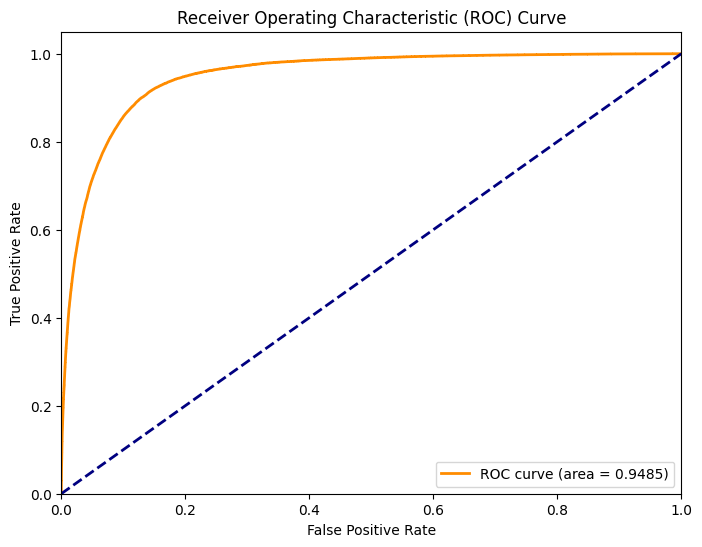

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# ROC 커브 계산: fpr, tpr, 임계치 값 반환
fpr, tpr, roc_thresholds = roc_curve(y_test, y_test_pred_prob)
roc_auc = auc(fpr, tpr)

# AUC 점수 출력
print("AUC-ROC Score: {:.4f}".format(roc_auc))

# ROC 커브 시각화
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # 무작위 분류 기준선
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [11]:
import shap
import matplotlib.pyplot as plt

# XGBoost 모델(bst)과 학습 데이터(X_train)가 이미 준비되었다고 가정

# TreeExplainer를 사용하여 SHAP 값 계산
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(X_train)

# SHAP Summary Plot (점 플롯)
shap.summary_plot(shap_values, X_train)

# 또는 SHAP Summary Plot (바 플롯)
shap.summary_plot(shap_values, X_train, plot_type="bar")


XGBoostError: [12:50:09] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api_utils.h:129: Check failed: std::accumulate(shape.cbegin(), shape.cend(), static_cast<bst_ulong>(1), std::multiplies<>{}) == chunksize * rows (51553964 vs. 14060172) : 